
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  CS207 Final Project Documentation 

Group 16 | Pirates of the SEAS | Michael Downs, Cameron Hickert, Dianne Lee, Wisoo Song 

<hr style="height:2pt">


## Table of Conents:
* [Introduction](#Introduction)
* [Background](#Background)
    * [Calculus](#Calculus)
    * [Forward Mode](#Forward-Mode)
    * [Dual Numbers](#Dual-Numbers)
    * [Reverse Mode](#Reverse-Mode)
    * [Gradient Descent](#Gradient-Descent)
    * [Newton's Method](#Newton's-Method)
    * [BFGS](#BFGS)
    * [Levenberg-Marquardt](#Levenberg-Marquardt)
* [How To Use](#How-To-Use)
    * [Installation](#Installation)
    * [Step-by-step demo of the installation](#Step-by-step-demo-of-the-installation)
    * [Using arrrtomatic to differentiate a simple function](#Using-arrrtomatic-to-differentiate-a-simple-function)
    * [Using arrrtomatic to differentiate a vector](#Using-arrrtomatic-to-differentiate-a-vector)
    * [Using arrrtomatic for Newton's Method](#Using-arrrtomatic-for-Newton's-Method)
    * [Using arrrtomatic for optimization](#Using-arrrtomatic-for-optimization)
* [Software Organization](#Software-Organization)
* [Implementation Details](#Implementation-Details)
* [Extension Features](#Extension-Features)
    * [Extension Feature 1: Reverse Mode](#Extension-Feature-1:-Reverse-Mode)
    * [Extension Feature 2: Optimization Routines](#Extension-Feature-2:-Optimization-Routines)
    * [Gradient Descent Examples](#Gradient-Descent-Examples)
    * [Newton's Method Examples](#Newton's-Method-Examples)
    * [BFGS Examples](#BFGS-Examples)
    * [Levenberg-Marquardt Examples](#Levenberg-Marquardt-Examples)

### Introduction

ARRRtomatic Differentiation is a Python package that implements forward and reverse mode automatic differentiation and several optimization routines using these techniques. Automatic Differentiation solves the problem of exactly computing the derivative (to machine precision) for an arbitrary function as long as that function can be expressed as the composition of elementary functions. Precise computation of the gradient is of fundamental importance in the sciences and applied mathematics. For example, many optimization algorithms rely on gradient information, and are therefore a prime application area for automatic differentiation, especially in a high dimensional setting. Indeed, the backpropagation algorithm, which is used to train neural networks, is simply gradient descent on the network's weights. Optimization algorithms find use in diverse tasks such as airport traffic planning, design of antennae, and portfolio allocation. 

Derivatives are also used in root finding methods such as Newton's method, which are used to numerically solve ordinary differential equations (ODEs) when using implicit methods, among other things. Reliable solutions to ODEs are integral to many of the applied sciences. Finally, gradient information is used in non-linear least squares fitting, which is a common procedure in statistical analysis. Therefore, to be widely useful, our package implements some general optimization routines, root finding, and non-linear least squares fitting. 

Automatic differentiation offers an improvement over finite difference methods in that automatic differentiation is exact to machine precision and does not suffer nearly as much from numerical stability issues. AD is also better than symbolic differentiation in that it is less computationally expensive.

### Background

#### Calculus

A derivative of a function represents the instantaneous rate of change of that function at a particular point. A vector containing each partial derivative of a multivariate function is known as a gradient and gives the direction of greatest increase at a particular point. A Jacobian of a vector-valued function is a matrix where each row contains the gradient of the corresponding function.

The chain rule describes the differentiation of a composite function, where the derivatives are taken at each step as described by the following diagram: 

![chain rule](./figures/chain_rule.png)

#### Forward Mode


Forward-mode automatic differentiation of a function can be conceptualized as 

1. Dividing that function into a composition of elementary operations through a computational graph. Basic elementary operations include:

    1. Addition
    2. Multiplication
    3. Subtraction
    4. Division
    5. Exponentiation
    6. Logarithms
    7. Trigonometric functions
    
2. Iteratively applying the chain rule, a result from calculus for computing the derivative of a composite function, at each step of the computational graph from beginning to end in order to propagate the exact values of the partial derivatives to machine precision all the way until the final step of the computational graph, which represents the output of the function. The partial derivatives at the final step are with respect to the function's variables and so represent the value of the gradient (to machine precision) for a chosen value of the function's variables.


The procedure described above allows for computation of particular classes of multivariate, scalar-valued functions, and can easily be extended to vector-valued functions as well -- simply apply the procedure component-wise to each function.

We illustrate both the graph structure of computations as well as the propagation of the derivatives via the chain rule with an example. As each step in automatic differentiation involves a single elementary function, each of these "steps" can be used as input into an outer function. An example of forward-mode automatic differentiation of the function *sin(2x)* can be seen below, where *x<sub>n</sub>* represents the *n*th step of the function. 

![graph struct](./figures/graph_structure.PNG)

| trace | func        | value   | deriv                 |   dx |
|-------|-------------|---------|-----------------------|-------|
| *x<sub>1</sub>* | *x<sub>1</sub>*       | 5     | 1           |     1 |
| *x<sub>2</sub>* | 2*x<sub>1</sub>*      | 10    | 2d*x<sub>1</sub>*          |     2 |
| *x<sub>3</sub>* | sin(*x<sub>2</sub>*) | -.544 | cos(*x<sub>2</sub>*)*dx<sub>2</sub>* | -1.68 |

Essentially, we divide the composite function sin(2x) into the elementary operations *x<sub>1</sub>*=x, *x<sub>2</sub>*=2*x<sub>1</sub>*, and *x<sub>3</sub>*=sin(*x<sub>2</sub>*), and we maintain the derivatives along the way. 

More generally, forward mode is able to compute the Jacobian of a general vector-valued function. We first introduce a seed vector p in order to calculate the directional derivative in the direction of p. For example, for a simple function *f(x,y)*, p = (1,0) would give us $\frac{d f}{d x}$ while $p = (0,1)$ would give us $\frac{d f}{d y}$. The forward mode calculates the product of the function gradient with this seed vector. 

In particular, the forward mode computes the Jacobian-vector product. The Jacobian matrix is defined $J = \frac{df_i}{ dx_j}$. Thus we can see that the forward mode of automatic differentiation computes the matrix-vector product $Jp$ for the seed vector $p$. 

Given a function $f: \mathbb{R}^m \rightarrow \mathbb{R}^n$, forward mode is more efficient when $n >> m$ as this correponds to the case where the number of functions to evaluate is greater than the number of inputs. 

#### Dual Numbers

It is also useful to give some background on dual numbers. Dual numbers are numbers of the form *a+bε*. In the case of automatic differentiation, the *ε* value can be used to represent the derivative of the function at a particular value *x*. For example, an element *x* would be represented as the vector *(x,x')*. A simple application of a function *f* might look like *f((x,x')) = (f(x), f(x)x')*, making use of the chain rule as described above. 

#### Reverse Mode

In the reverse mode of automatic differentiation, as opposed to the forward mode, the intermediate values are calculated first and then the chain rule is used to calcuate the gradients in a back-to-front approach. This is shown in the figure below, where $v_k$ is the current value for the calculation of the gradient $\frac{df}{dv_k}$. 

<img src="./figures/reverse_mode.png" alt="reverse mode"/><br/>

Reverse mode requires two passes. First the forward pass computes the values each step of the way, and the reverse pass then computes the gradients using the chain rule. Because all gradients are not computed at each step -- instead, it's a local calculation -- reverse mode is more computationally efficient. 

Rreverse mode is more efficient than forward mode when $n << m$, or the number of inputs is larger than the number of functions, as is common in deep learning applications. Reverse mode in this case computes the product $J^Tp$ instead. 

#### Gradient Descent

Gradient Descent in a simple first-order optimization algorithm that attempt to find $x^* \in \mathbb{R}^n$ such that $f(x^*) \le f(x) \forall x \in  \mathbb{R}^n$. It does so by moving in the direction of steepest descent, $-\nabla f$, the negative of the gradient.
<br/>
<img src="./figures/gradient_descent.png" alt="drawing" height="150"/><br/>

There are variants of gradient descent but, broadly speaking, the algorithm is as follows:

<br/>
<img src="./figures/gradient_descent_algo.png" alt="drawing" height="100"/><br/>

Oftentimes one wishes to optimize over a loss function with respect to some parameters where the loss function is the sum of losses of individual data points. That is, one wishes to optimize over

$$L(\theta) = \frac{1}{N}\sum_{i=1}^N L(x_i; \theta)$$ 

Instead of taking the gradient of the entire loss function, one can sample a few points randomly, take the gradient with respect to those points, and then take a step using this approximation to the gradient. The SGD algorithm is then:
![sgd](./figures/sgd_algo.png)

In our package, we implement momentum, adagrad, and adam, which are modifications that often improve the performance of GD/SGD.

Momentum uses an exponentially decaying average of the previous gradient descent steps in the update rule. The symmetric cancellation allows the steps to perform better in situations where they would otherwise exhibit a zig-zag pattern.

The update rule becomes (in the equations below, the gradient can be substituted with the mini-batch approximation $\widehat{\nabla f(x)}$   ):

![momentum](./figures/momentum.png)

AdaGrad scales the step size for each parameter by a quantity which incorporates information on how quickly the function is changing with respect to that parameter. The step size is usually uniform across all parameters, but adaptively scaling the step sizes on a per-parameter basis allows for more robust steps. The adagrad steps are:

<br/>
<img src="./figures/adagrad.png" alt="drawing" height="90"/><br/>

Adam combines these two ideas by maintaining an exponentially decaying running average of both the previous gradient steps and square of the gradient, and has the updates:

![adam](./figures/adam.png)

In practice, Adam performs well on a wide variety of loss surfaces.

#### Newton's Method

Newton’s method is an iterative procedure for finding the roots of a function. It works by choosing an initial guess, finding the best linear approximation to the function at that point, and then determining the roots of the linearization, which is an easy problem with a closed-form solution. 

In the univariate case, one can intuit Newton's method as iteratively finding where the tangent line to the function at the current guess intersects the x axis and then choosing the intersection point as the next guess:
<br/>

![newton1d](./figures/newton_1d.png)
![newton1d](./figures/newton_1d_intuition.png)

In the multivariate case, one can analogously use a first order taylor approximation and solves that system for where it equals the zero vector.
![newtonNd](./figures/newton_multivariate.png)

Equating the right hand side above with the 0 vector, we obtain the update:
$$J\Delta x = -F(x)$$

In the general case, the algorithm is: 
![newtonNd](./figures/newton_root_algo.png)

Newton's Method can also be used for optimization -- simply run it on the gradient of a function to find where the first order conditions for optimality are satisfied. In this case, the algorithm becomes:

![newtonNd](./figures/newton_opt_algo.png)

where $H$ is the Hessian.

#### BFGS

BFGS (Broyden-Fletcher-Goldfarb-Shanno) is a Quasi-Newton method that performs Newton-like updates of the form 

$$\Delta x = -B^{-1} \nabla f(x)$$

except $B$ is an approximation of the Hessian that is iteratively updated as more function evaluation are taken.

The BFGS algorithm is (credit to Chris Rycroft for image):
![bfgs](./figures/bfgs_algo.png)

where

![bfgs](./figures/bfgs_update.png)

A full discussion of where the updates come from is beyond the scope of this documentation and we direct the reader to https://www.stat.cmu.edu/~ryantibs/convexopt/lectures/quasi-newton.pdf.

Because BFGS uses an approximation of the Hessian, it typically has faster convergence than a first order method but slower convergence than a second order method. The benefit of BFGS vs using the full Newton's Method iterations is that it is less costly to perform the B matrix update and one does not need the second order partial derivatives.

#### Levenberg-Marquardt

Levenberg-Marquardt is an iterative algorithm for fitting parameters in a nonlinear least squares problem that improves upon Gauss-Newton, the canonical algorithm for nonlinear least squares fitting, by adding additional stability.

Suppose that we have a response variable $y$ and a collection of covariates $X$ that are related in a non linear manner through the function $d(X; \theta)$ with parameters $\theta$. In nonlinear regression we with to minimize the quantity $\frac{1}{2} \sum_{i=1}^N (y - d(x_i; \theta))^2 = \frac{1}{2} \sum_{i=1}^N (r_i)^2 = \frac{1}{2}||\mathbf{r(\theta)}||^2$. Then, the first order conditions are:

$$
J_r(\theta)^T r(\theta) = 0
$$

Due to the non-linearity, this system does not have a closed-form solution. One can, however, use Newton's method to find the value of $\theta$ that achieves the first order conditions. 

Deriving the Newton updates yields a term containing the product of a second order partial derivative and an element of the residual vector. This term is discarded because determining the second order partial derivative is burdensome and we would expect the components of the residual vector to be small near the root. Finally, a diagonal matrix is added to the left hand side matrix in the Newton updates to increase numerical stability.

The Levenberg-Marquardt algorithm is then:
![](./figures/lm_algo.png)


### How To Use

##### Installation

   We utilized the setuptools module to package and upload our module on PyPI. This method is much more robust than simply freezing the dependencies using 'pip freeze > requirements.txt'. In addition to solving messy dependency issues, including the setup.py allows the package to be directly installed to venv or conda env by running the following code:
    <img src="./figures/pip_install_command.png" alt="drawing" width="250"/><br/>
    Detailed information about the project and python kernel compatibility can be found at: https://pypi.org/project/arrrtomatic/ . Notice that arrrtomatic only supports python kernel 3.6 and up.

<img src="./figures/PyPI.png" alt="drawing" width="400"/>

##### Step-by-step demo of the installation
1. If you have not created an environment for your project, create one. We recommend python 3.6 and conda envs.<br/>
<img src="./figures/conda_create.png" alt="drawing" height="150"/><br/>
2. Activate the environment
<img src="./figures/conda_activate.png" alt="drawing" height="150"/><br/>
3. pip install arrrtomatic <br/>
<img src="./figures/successful_install3.png" alt="drawing" width="550"/><br/>
4. import the module with:<br/>
<center> from ARRRtomatic_diff import Autodiff </center><br/>
<img src="./figures/assertion_success2.png" alt="drawing" width="550"/><br/>

5. Local Testing interface for developers <br/>

 In the project directory, developers could use 'setup.py' with the 'test' option to run test cases locally and simulate user's installation environment. Running the following line finds the test_*.py files from the tests/ folder and runs it with pytest:<br/>
<img src="./figures/setup_test.png" alt="drawing" width="600"/><br/>

##### Using arrrtomatic to differentiate a simple function

In [1]:
import sys
import numpy as np
!{sys.executable} -m pip uninstall -y arrrtomatic
!{sys.executable} -m pip install --user arrrtomatic

  Using cached https://files.pythonhosted.org/packages/b8/b6/1b1a7607f9730b6f4218f603721a28a7aa91deeae9b9022923fc91a86201/arrrtomatic-1.0.12-py2.py3-none-any.whl


In [2]:
#Import the modules!
from ARRRtomatic_diff import AutoDiff, AutoDiffVector
from ARRRtomatic_diff.functions import sin, exp, sqrt, log


Let's determine the derivative of sqrt at x=3.

- Create an AutoDiff object for a variable by passing arguments 'name' and 'val'

In [3]:
x = AutoDiff(name='x', val=3)

print(sqrt(x))

{'val': 1.7320508075688772, 'd_x': 0.2886751345948129}


- The 'val' inside x.trace keeps track of the current value of the variable. The value can be retrieved by calling x.get_value().
- The 'd_(variable name)' inside x.trace records the derivative of the variable with respect to (variable name). 
  

In [4]:
print(x.get_value())
print(x.get_gradient()) # could also call x.get_trace()['d_x']

3
(array([1.]), ['x'])


- The trace table is managed internally by each AutoDiff instance.

In [84]:
y = AutoDiff(name='y', val=4)
z = y * x
print(f"The graident of z is : {z.get_gradient()}")
print(z)
print(y)

The graident of z is : {'d_x': 4, 'd_y': 3}
{'val': 12, 'd_x': 4, 'd_y': 3}
{'val': 4, 'd_y': 1}


##### Using arrrtomatic to differentiate a vector

We now demonstrate how to use the AutoDiffVector class.

In [5]:
#First instantiate AutoDiff variables like before
x1 = AutoDiff(name='x1', val=-1)
x2 = AutoDiff(name='y1', val=3)

Note that AutoDiffVector is created from an iterable of AutoDiff instances.

In [6]:
u = AutoDiffVector((x1, x2))
v = AutoDiffVector((-x2, x1))
q = [2, 1.5]

w = u+q
print(w)
print((w).val == [1, 4.5])
#Can verify that our module appropriately calculates 
#the derivative of a constant vector
J, order = (w).get_jacobian()  
print(J)

[{'val': 1, 'd_x1': 1},{'val': 4.5, 'd_y1': 1}]
[ True  True]
[[1. 0.]
 [0. 1.]]


Now let's try a more useful case where we differentiate a AutoDiffVector with its elements are expressed in more than one variable. Note that our Jacobian follows the column vector convention.

In [7]:
w2 = u+v   # [x1] + [-x2]  = [x1-x2] ==> expressed in column form to make it easier to visualize
           # [x2]   [x1 ]    [x2+x1]

Calculating the Jacobian of this should give   

<br/>
<img src="./figures/jacobian.png" alt="drawing" width="300"/><br/>


In [8]:
J2, order = w2.get_jacobian() # 

print(J2)

[[ 1. -1.]
 [ 1.  1.]]


##### Using arrrtomatic for Newton's Method

In [9]:
def f(x, g):
    x = AutoDiff(name='x', val=x)
    auto_diff_results = g(x)
    return auto_diff_results.get_value(), auto_diff_results.get_trace()['d_x']

def do_newtons_method(x, f,g, tol=1e-6, verbose=0):
    """
    x: initial guess
    f: function that returns value and derivative of f at x
    tol: terminate when the absolute value of f at x is less than or equal to the tol
    """
    num_iters = 1
    while abs(f(x,g)[0]) > tol:
        val, deriv = f(x,g)

        if verbose > 0:
            print(f"Iteration {num_iters} | x: {x:2f} | f(x): {val:2f} | deriv: {deriv:2f}")
        x = x - val/deriv
        num_iters += 1

    if verbose > 0:
        print(f"Converged to {x} after {num_iters} iterations\n")

    return x



In [10]:
sin1=do_newtons_method(0.2, f, sin,verbose=1)
sin2=do_newtons_method(2.2, f, sin, verbose=1)
sqrt1=do_newtons_method(0.2, f, log,verbose=1)

Iteration 1 | x: 0.200000 | f(x): 0.198669 | deriv: 0.980067
Iteration 2 | x: -0.002710 | f(x): -0.002710 | deriv: 0.999996
Converged to 6.634450606078646e-09 after 3 iterations

Iteration 1 | x: 2.200000 | f(x): 0.808496 | deriv: -0.588501
Iteration 2 | x: 3.573823 | f(x): -0.418897 | deriv: -0.908034
Iteration 3 | x: 3.112500 | f(x): 0.029089 | deriv: -0.999577
Iteration 4 | x: 3.141601 | f(x): -0.000008 | deriv: -1.000000
Converged to 3.141592653589793 after 5 iterations

Iteration 1 | x: 0.200000 | f(x): -1.609438 | deriv: 5.000000
Iteration 2 | x: 0.521888 | f(x): -0.650303 | deriv: 1.916121
Iteration 3 | x: 0.861273 | f(x): -0.149344 | deriv: 1.161072
Iteration 4 | x: 0.989899 | f(x): -0.010153 | deriv: 1.010204
Iteration 5 | x: 0.999949 | f(x): -0.000051 | deriv: 1.000051
Converged to 0.9999999986897259 after 6 iterations



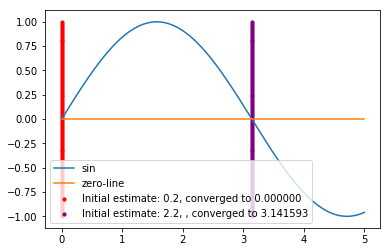

In [11]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x_s =np.linspace(0, 5, 500)
y_s =np.linspace(-1,1, 100)

sin_dots = np.sin(x_s)
plt.plot(x_s,sin_dots)
plt.plot(x_s,[0]*500)
plt.scatter([sin1]*100, y_s, color="red", s=10)
plt.scatter([sin2]*100, y_s, color="purple", s=10)
plt.legend(["sin", "zero-line", f"Initial estimate: 0.2, converged to {sin1:2f}", f"Initial estimate: 2.2, , converged to {sin2:2f}"])

##### Using arrrtomatic for optimization

Let's import some more modules to visualize how our optimization
module performs

In [12]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

In [13]:
from ARRRtomatic_diff import optimization
from ARRRtomatic_diff.optimization.gradient_descent import *

Below is the Rosenbrock function to test the performance of our optimization methods

In [14]:
def rosen(x, y):
    term1 = 100 * (y - x ** 2) ** 2
    term2 = (1 - x) ** 2

    total = term1 + term2
    return total

The following 3 methods are simply for visualizing purposes

In [15]:
def render_descent(length, w_path, dims=2):
    """
    redering descent path with updates

    length is # of points for the line.
    dims is dimensions in the mapping space
    """
    x0, y0 = w_path[0]
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.array([x0,y0, rosen(x0,y0)])
    for index in range(1, length):
        x, y = w_path[index]
        z = rosen(x, y)
        lineData[:, index] = np.array([x,y,z])

    return lineData

def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

def update_lines2(num, dataLines, lines, dataLines2, lines2):
    for line, data, line2, data2 in zip(lines, dataLines,lines2, dataLines2):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
        line2.set_data(data2[0:2, :num])
        line2.set_3d_properties(data2[2, :num])
    return lines, lines2

Let's plot the meshgrid of the Rosenbrock function

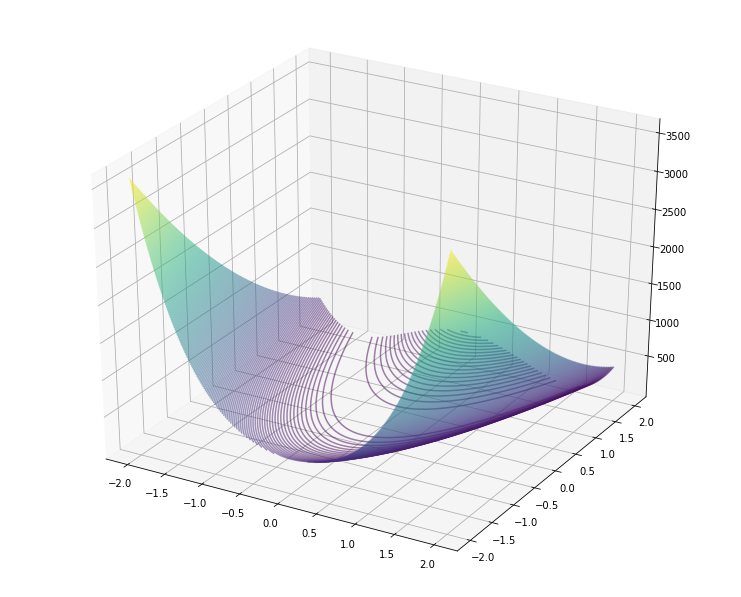

In [16]:
# attaching 3D axis
fig = plt.figure(figsize=(10,8))
ax = p3.Axes3D(fig)

num_points = 3000
x = np.linspace(-2.0, 2.0, num_points)
y = np.linspace(-2.0, 2.0, num_points)
X, Y = np.meshgrid(x,y)
# print(X)
z = [rosenbrock((x[i], y[i]))[0].get_value() for i in range(num_points)]

Z = rosen(X, Y)

ax.contour3D(X,Y,Z, 200, alpha=0.5)

- do_gradient_descent() performs gradient descent with many options. You can also set use_momentum=True to enable momentum.

In [18]:
w0 = np.array([-1.9,1.96])#initial point
                            #function to descend upon  = rosenbrock          
gd_path = do_gradient_descent(w0, rosenbrock, max_iter=num_points, step_size=0.0015, show=True)

Did not converge after 3000 steps


- The code below takes about 5 minutes on MacBookAir (due to video rendering). If you want to see the video right away, check under '/docs/figures/'GRRRadient_Descent_no_momentum.mp4' OR <br/>
'/docs/figures/'GRRRadient_Descent_momentum.mp4'

In [20]:
batch = 1000
frame = 60
interval = 30
data = [render_descent(frame, gd_path, 3) for index in range(batch)]

# Had to do the following because can't pass 3d vector to ax.plot
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], color="red")[0] for dat in data]

ax.set_xlim3d([-2.0, 2.0])
ax.set_xlabel('X')
ax.set_ylim3d([-2.0, 2.0])
ax.set_ylabel('Y')
ax.set_zlim3d([0.0, 2500.0])
ax.set_zlabel('Z')
ax.set_title('GRRRADIENT Descent! (Global Minimum = (0,0))')

# Rendering the animation!
#                                  fig  func to update frame      updated func's args, interval
line_ani = animation.FuncAnimation(fig, update_lines, frame, fargs=(data, lines),
                                   interval=interval, blit=False)
Writer = animation.FFMpegWriter()
ax.plot3D([0], [0], [0], marker='x', color='green')
ax.legend([f'Starting point: ({-1.9}),({1.96}), no Momentum'], loc='upper right')
##make sure you have ffmpeg installed!
print(animation.writers.list())

# *******uncomment the following line if you want to save the video******
# line_ani.save('GRRRadient_Descent_no_momentum.mp4', writer=Writer)

['ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']


The resulting video will look similar to this:

In [21]:
from IPython.display import Video
Video("./figures/GRRRadient_Descent_no_momentum.mp4", width=500)

In [22]:
Video("./figures/GRRRadient_Descent_momentum.mp4", width=500)

### Software Organization 

At a high level, our software is organized into implementation, documentation, and tests. Our package is organized into two main modules which house the AutoDiff objects and the elementary functions, respectively, and the optimization subpackage which implements the optimization routines in separate modules. The functions reside in a subpackage for stylistic reasons so that users can explicitly import these functions from \"ARRRtomatic_diff.functions\"\n",

A more detailed directory structure is as follows:
```
. 
├── ARRRtomatic_diff
│   ├── README.md
│   ├── __init__.py
│   ├── auto_diff.py
│   ├── optimization
│       ├── README.md
│       ├── __init__.py
│       ├── bfgs.py
│       ├── gradient_descent.py
│       ├── levenberg_marquardt.py
│       └── newton.py
│   └── functions <br>
│       ├── __init__.py 
│       └── funcs.py
│       └── README.md
├── LICENSE.txt
├── README.md 
├── docs 
│   ├── documentation.ipynb
│   ├── milestone1.md
│   ├── milestone2.ipynb
│   └── grrradient_demo.py
├── driver_script.py
├── .gitignore
├── .travis.yml
├── requirements.txt
├── setup.cfg
├── setup.py
└── tests 
    ├── __init__.py
    ├── test_elementaryoperations.py
    ├── test_elementaryoperations_reversemode.py
    ├── test_elementaryoperations_vectors.py
    ├── test_elementaryoperations_reversemode_vectors.py
    ├── test_instantiation.py
    ├── test_instantiation_reversemode.py
    ├── test_instantiation_reversemode_vectors.py
    ├── test_instantiation_vectors.py
    ├── test_intermediateoperations.py
    ├── test_intermediateoperations_reversemode.py
    ├── test_intermediateoperations_reversemode_vectors.py
    ├── test_intermediateoperations_vectors.py
    ├── test_optimization.py
    └── test_trigs.py
    └── test_trigs_reversemode.py
    └── test_trigs_reversemode_vectors.py
    └── test_trigs_vectors.py
```

The basic modules are auto_diff.py and funcs.py. auto_diff.py contains the AutoDiff, AutoDiffVector, AutoDiffRev, and AutoDiffRevVector classes, which use operator overloading to implement forward and reverse mode automatic differentiation for elementary arithmetic operations. The overloaded operations use duck typing to update the values and partial derivatives correctly depending on whether the other term is an AutoDiff(Rev) object or a numeric. Our AutoDiff(Rev)Vector also supports intelligent contextual broadcasting of operations. funcs.py defines elementary functions such as exp and trig functions which use duck typing to appropriately update the value and gradient for supplied AutoDiff(Rev) objects or simply perform the elementary computation if the argument is a numeric. The optimization subpackage contains the modules bfgs.py, gradient_descent.py, levenberg_marquardt.py, and newton.py. Each module contains an implementation of the appropriate algorithm as well as some example functions to be used with the algorithm.

We follow PEP 257 https://www.python.org/dev/peps/pep-0257/ for our docstrings. Because of our extensive unit tests, we do not use doctests.

The tests reside in a directory at the same level as our ARRRtomatic_diff directory and are run via pytest. They are integrated via Travis CI and CodeCov.

We use setuptools (https://packaging.python.org/tutorials/packaging-projects/) to package our software. 

See the previous section for a discussion of how to install and use the package. We use PyPI for our remote server for distribution. Hence, our package can easily be installed with pip.

### Implementation Details

We implemented the forward mode of automatic differentiation through operator overloading and defining custom functions for cases where operator overloading does not make sense (i.e. exp, sin, etc.). That is, for each of the elementary operations (add, subtract, etc.), we overloaded the appropriate dunder method in our AutoDiff(Vector) class. Note that for each of the elementary operations, this also included overloading the reverse operands (`__rmul__`, `__radd__`, etc.). The overloaded methods appropriately update both the value and all the partial derivatives. We accounted only for the real numbers and throw exceptions for cases where the derivative is not defined (division by zero, log of a negative number, etc.).

<img src="./figures/operations.png" alt="drawing" width="500"/>

Our core classes, AutoDiff(Vector) / AutoDiffRev(Vector), are a representation of a particular row in the trace table, which in turn corresponds to a step in the computational graph. We discuss the reverse cases further below, so will focus on the forward mode in this section. Users interact with it by instantiating named variables that represent root nodes in the computational graph (which corresponds to the inputs to the *n* initial rows of the trace table, where *n* represents the number of input variables). Users can then create arbitrarily complicated functions by manipulating these variables with elementary operations. At every step, the object handles maintaining the derivatives and the function value. Once the user has finished composing a function, the final derived AutoDiff(Vector) object corresponds to the final row in the trace table and has the function value and gradient.


For example:

```python
from ARRRtomatic_diff import AutoDiff
from ARRRtomatic_diff.functions import sin, exp, sqrt, log

x = AutoDiff(name='x', val=2)
y = AutoDiff(name='y', val=-2)
z = AutoDiff(name='z', val=10)

a = z*exp((x - y)**2 / z)

print(a)
{'val': 49.53032424395115, 'd_z': -2.9718194546370693, 'd_y': -39.62425939516092, 'd_x': 39.62425939516092}
```

We implemented all the basic operations (addition, multiplication, exponentiation, AND, XOR, etc.). These correspond to many standard dunder methods in Python. Most other dunder methods will operate directly on the "val" attribute in the trace dictionary (representing the value of the function composition) and will not use the derivatives. For example, if the val is 5, division modulo 2 will return 1.

The AutoDiff class has the properties trace and names_init_vals. Trace is a dictionary which keeps track of both the gradient and the current value of the function. self.names_init_vals is another dictionary which keeps track of all variable names seen thus far in all of AutoDiff objects in the trace table as well as their initial values.

The AutoDiff class exposes a few methods to access these properties, namely get_trace, get_named_variables, get_names_init_vals, get_value, and get_gradient. The user can access get_gradient when they have finished writing their computational graph to get the final partials. The AutoDiff class also has the corresponding properties variables, val, and gradient as another way to access trace and named_variables. get_gradient returns a 1D numpy array containing the gradient as well as the order of its entries. The user can specify an order.

```python
print(a.get_trace())
{'val': 49.53032424395115, 'd_x': 39.62425939516092, 'd_z': -2.9718194546370693, 'd_y': -39.62425939516092}
print(a.get_named_variables())
{'x', 'z', 'y'}
print(a.get_value())
49.53032424395115

>>> x = AutoDiff(name='x', val=3)
>>> y = AutoDiff(name='y', val=4)
>>> z = x + y
>>> z.get_names_init_vals()
{'x': 3, 'y': 4}
z.get_gradient(order=['y', 'x'])
(array([1., 1.]), ['y', 'x'])
```

The AutoDiff(Vector) classes handle combining two AutoDiff variables through the "private" \__update_binary_autodiff method. This function takes as arguments the other AutoDiff(Vector) object and the rule for updating the the values and the derivatives. The rule for updating the values will be a function of the two values of the AutoDiff(Vector) objects. The rule for updating the derivatives is a function of the values of the two AutoDiff(Vector) objects and the relevant partial derivatives as well. This method will combine the named variables for both AutoDiff objects as well. The result is a new AutoDiff object with an updated trace and set of named variables. There is also a check to enforce consistency among the initial values when combining variables. For example, if a user attempts to combine two auto diff objects that both have 'x', but with different initial values, then our implementation will throw an exception. This check is performed in the \__merge_names_init_vals(d1, d2) function.

There is another function, \__update_binary_numeric, which handles creating an updated AutoDiff(Vector) object in case that the other argument is a numeric primitive, which also returns an updated AutoDiff(Vector) object. This other method also takes as argument an update rule for the values and derivatives but, because the numeric is a constant, some simplifying assumptions are made for the update rule for the derivative.

For example, for multiplication, the update rules are:

```python
@staticmethod
def __mul(x, y):
    return x * y

@staticmethod
def __dmul(x, y, dx, dy):
    return dx*y + x*dy
```

and when an AutoDiff object is multiplied by another entity, the following overloaded dunder method gets called:

```python
def __mul__(self, other):
    try:
        return self.__update_binary_autodiff(other, AutoDiff.__mul, AutoDiff.__dmul)
    except AttributeError:
        return self.__update_binary_numeric(other, AutoDiff.__mul, AutoDiff.__dmul)
```

If a numeric, say, 4.3, were multiplied, dy would be set to 0 for the above derivative update rule.  

Instantiating the AutoDiff(Vector) object requires passing in certain named arguments which change depending on the context. We assume that these objects will only ever be initialized in exactly one of two contexts. The user should only ever interact with the first context. Those wishing to extend the library will need to understand the second context.

The contexts are: 

1. A user creates an AutoDiff object for the first time in which case the arguments 'name' and 'val' are passed. 'name' in this case is a string representing the variable name and 'val' is a numeric representing the value of the variable. 
2. A call from inside a function corresponding to an elementary operation, in which case the trace is assumed to have been pre-computed and the arguments are 'trace' and 'name'. 'trace' is a dictionary with the function value and partial derivatives. 'name' in this case is a dictionary where the keys are variable names and the values are the initial values. 

The elementary operations, which reside in funcs.py, interact with an AutoDiff(Vector) / AutoDiffRev(Vector) object in a similar manner, and update them via the "private" __update_unary(x, operation, doperation) method while takes as input an AutoDiff variable or primitive numeric and the rules for updating the value and partial derivatives.

For example, the update rules for sin would be:

```python
def sin(x):
    return __update_unary(x, np.sin, np.cos)
```

In addition to AutoDiff, we also implement AutoDiffVector, which can be conceptualized as an ordered collection of AutoDiffs. AutoDiffVector assumes that the input is an iterable of AutoDiff objects and internally stores them in the \__auto_diff_variables attribute as a list. The AutoDiffVector class also keeps track of all named variables it has encountered in its named_variables attribute. 

The AutoDiffVector class supports the get_named_variables, get_values, and get_jacobian methods. get_named_variables  returns a set containing all of the named variables among all of the AutoDiff objects. get_values returns a 1D numpy array containing the current values for each AutoDiff object. get_jacobian returns a matrix where the ith row is the gradient of the the ith AutoDiff object with whatever order the user specifies. If the order is not specified, alphabetical order is used. In addition to returning the matrix, get_jacobian also returns the variable order for the columns.

```python
>>> x = AutoDiff(name='x', val=3)
>>> y = AutoDiff(name='y', val=4)
>>> z = x + y

adv = AutoDiffVector([x, z, y])
>>> adv.get_named_variables()
{'y', 'x'}
>>> adv.get_values()
array([3, 7, 4])
>>> adv.get_jacobian(order=['x', 'y'])
(array([[1., 0.],
       [1., 1.],
       [0., 1.]]), ['x', 'y'])
```

the named variables, values and jacobian are also accessible through the properties 'variables', 'val', and 'jacobian'. 

AutoDiffVector supports scalar and vector operations with other AutoDiffVectors or other iterables. If attempting to perform a binary operation with a scalar, the binary operation will be broadcasted to each element of the AutoDiffVector. The derivatives and values of each AutoDiff object will be updated appropriately depending on whether the scalar is a numeric primitive or an AutoDiff. When performing a binary operation with another iterable of the same length, possibly an AutoDiffVector, the operation is performed element-wise. Unary operations are broadcasted to each element. For example:

```python
>>> x = AutoDiff(name='x', val=1)
>>> y = AutoDiff(name='y', val=3)
>>> x
AutoDiff(names_init_vals={'x': 1}, trace="{'val': 1, 'd_x': 1}")
>>> y
AutoDiff(names_init_vals={'y': 3}, trace="{'val': 3, 'd_y': 1}")
>>> u = AutoDiffVector([y, -x])
>>> v = AutoDiffVector([x**2, y])
>>> u
AutoDiffVector(names_init_vals=[AutoDiff(names_init_vals={'y': 3}, trace="{'val': 3, 'd_y': 1}"),AutoDiff(names_init_vals={'x': 1}, trace="{'val': -1, 'd_x': -1}")]
>>> 3*u
AutoDiffVector(names_init_vals=[AutoDiff(names_init_vals={'y': 3}, trace="{'val': 9, 'd_y': 3}"),AutoDiff(names_init_vals={'x': 1}, trace="{'val': -3, 'd_x': -3}")]
>>> u + v
AutoDiffVector(names_init_vals=[AutoDiff(names_init_vals={'y': 3, 'x': 1}, trace="{'val': 4, 'd_y': 1, 'd_x': 2}"),AutoDiff(names_init_vals={'x': 1, 'y': 3}, trace="{'val': 2, 'd_x': -1, 'd_y': 1}")]
>>> sin(u)
AutoDiffVector(names_init_vals=[AutoDiff(names_init_vals={'y': 3}, trace="{'val': 0.1411200080598672, 'd_y': -0.9899924966004454}"),AutoDiff(names_init_vals={'x': 1}, trace="{'val': -0.8414709848078965, 'd_x': -0.5403023058681398}")]
```

The method implementing this broadcasting logic is called "combine" and takes as input two objects to be combined using either scalar / operations as well as the appropriate binary operation. "combine" detects the form of the object and acts accordingly. We have also updated \__update_unary in the functions module to detect whether it is being passed an AutoDiffVector and broadcast the operation if so. Finally, we have modified the dunder methods in the AutoDiff object to detect if it's being combined with an AutoDiffVector 

```python
def __add__(self, other):
        return AutoDiffVector.combine(self, other, lambda x,y: x+y)
```


We use NumPy and SciPy for elementary computations and other operations. Beyond benefitting our package with its speed and versatility, NumPy's prevalence among the Python programming community will allow those interested to more easily understand how our packages operates "under the hood," especially to understand which operators we have overloaded.  

Beyond NumPy, our package does not have other external dependencies. We use pytest for the tests.

The currently implemented elementary functions are:
* exp
* log
* sqrt
* sin
* cos
* tan
* csc
* sec
* cot
* arcsin
* arccos
* arctan
* arccsc
* arcsec
* arccot
* sinh
* cosh
* tanh
* csch
* sech
* coth
* arcsinh
* arccosh
* arctanh
* arccsch
* arcsech
* arccoth





### Extension Features









#### Reverse Mode

The first extension feature we implemented was the reverse mode of automatic differentiation. A more detailed background of reverse mode can be found in the "Background" section. Here we describe its implementation and use. 

The core classes of the reverse mode implementation are AutoDiffRev for the scalar implementation and AutoDiffRevVector for the vector generalization. 

Reverse mode extends the AutoDiff class for the forward mode but has a few key differences. Primary among these is that it starts with the output and works towards the input. Thus, a primary difference in implementation is that the AutoDiffRev class first makes a forward pass to calculate and store the values in an array of tuples named "children." At each step, the local computation of the gradient is local, so it only requires the current value, the gradient with respect to each child, and the derivative of each function describing each child's dependence on the parent. The computation graph of f is stored as a directed graph keeping track of each of these three values and uses them to compute its own gradient.

In order to make this use case robust, we keep a set of breadcrumbs to keep track of each variable in the computation graph. Each variable is uniquely identified by a signature generated using an MD5 hash. The gradient is calculated by propagating backwards through these. 

Users can interact with the reverse mode in a similar way to forward mode, by instantiating named variables that represent root nodes in the computational graph (which corresponds to the inputs to the *n* initial rows of the trace table, where *n* represents the number of input variables). Users can then create arbitrarily complicated functions by manipulating these variables with elementary operations. The final derived AutoDiffRev(Vector) object corresponds to the final row in the trace table and has the function value and gradient.

For example:

```python
from ARRRtomatic_diff import AutoDiffRev
from ARRRtomatic_diff.functions import sin, exp, sqrt, log

x = AutoDiffRev(name='x', val=2)
y = AutoDiffRev(name='y', val=-2)
z = AutoDiffRev(name='z', val=10)

a = z*exp((x - y)**2 / z)

print(a)
{'val': 49.53032424395115, 'd_z': -2.9718194546370693, 'd_y': -39.62425939516092, 'd_x': 39.62425939516092}
```

Note that this is the same syntax and result as forward mode. We implemented all the basic operations (addition, multiplication, exponentiation, AND, XOR, etc.), as described in the forward mode section. The AutoDiffRev class has the properties trace and names_init_vals, the same as with AutoDiff in forward mode, and retains the same methods to access these properties. We made this design choice in order to make utilizing both forward and reverse mode simpler for the end user. 

Like the AutoDiff and AutoDiffVector classes, the AutoDiffRev and AutoDiffRevVector classes also handle combining two objects through the "private" _update_binary_autodiff method. One difference is that when overloading the addition and multiplication operators, each class stores a reference to the parent object in order to later compute the gradient. Analogous to the case above, the output here is a new AutoDiffRev(Vector) object. 

For example, for multiplication, while the update rules are the same as in forward mode previously, when an AutoDiff object is multiplied by another entity, the following overloaded dunder method gets called:

```python
def __mul__(self, other):
        # get random signature defining paths
        sig1 = generate_signature()
        sig2 = generate_signature()
        
        # update breadcrumbs with signatures
        updated_breadcrumbs = self.breadcrumbs | \
                              other.breadcrumbs| \
                              set([sig1])             | \
                              set([sig2])     

        # keep track of root variables
        updated_root_vars = self.root_vars | other.root_vars
        
        z = AutoDiffRev(self.value * other.value, updated_breadcrumbs, updated_root_vars)
        self.children.append((other.value, z, sig1))
        other.children.append((self.value, z, sig2))
        return z
```

We see that the key differences between this overloaded method and the one for forward mode is that we must keep track of each unique variable, and append the appropriate values to each object's intermediate values array. 

Again similarly to forward mode, a user can instantiate the AutoDiffRev(Vector) object by passing in the arguments 'name' and 'val,' where 'name is the variable name as a string and 'val' is the value of the variable as a numeric. 

The elementary operations, which reside in funcs.py, interact with an AutoDiff(Vector) / AutoDiffRev(Vector) object in a similar manner, and update them via the "private" __update_unary(x, operation, doperation) method while takes as input an AutoDiff variable or primitive numeric and the rules for updating the value and partial derivatives.

As alluded to, in addition to AutoDiffRev, we also implement AutoDiffRevVector, which can be conceptualized as an ordered collection of AutoDiffRevs. AutoDiffRevVector assumes that the input is an iterable of AutoDiffRev objects. As AutoDiffVector, the AutoDiffRevVector class supports the get_named_variables, get_values, and get_jacobian methods.

```python
>>> x = AutoDiffRev(name='x', val=3)
>>> y = AutoDiffRev(name='y', val=4)
>>> z = x + y

adv = AutoDiffRevVector([x, z, y])
>>> adv.get_named_variables()
{'y', 'x'}
>>> adv.get_values()
array([3, 7, 4])
>>> adv.get_jacobian(order=['x', 'y'])
(array([[1., 0.],
       [1., 1.],
       [0., 1.]]), ['x', 'y'])
```

Note that the syntax above is interchangeable with AutoDiffVector. 

AutoDiffRevVector also supports scalar and vector operations with other AutoDiffRev Vectors or other iterables in the same manner as AutoDiffVector. The method implementing this broadcasting logic is also called "combine" and takes as input two objects to be combined using either scalar / operations as well as the appropriate binary operation. "combine" detects the form of the object and acts accordingly. We have also updated \__update_unary in the functions module to detect whether it is being passed an AutoDiffRevVector and broadcast the operation if so. Finally, we have modified the dunder methods in the AutoDiffRev object to detect if it's being combined with an AutoDiffRevVector 

As with forward mode, we use NumPy and SciPy for elementary computations and other operations. We also use hashlib and the default random libraries in order to generate unique identifiers for our bradcrumbs. We use pytest for the tests.

#### Optimization Routines

For our second extension feature, we implemented several optimization routines:

* Root-finding: Newton’s Method
* Non-linear least squares: Levenberg-Marquardt
* First-order optimization: BFGS: 
* First-order optimization: Gradient Descent / Stochastic Gradient Descent and variations

Please see an explanation of these algorithms in the "Background" section. In this section we will describe their usage.


#### Gradient Descent

Our gradient descent implementation is located in the gradient_descent.py module in the optimization subpackage and takes as input an initial start value, a function which takes as input a 1d numpy array and returns an autodiff object and the correct order of the variables, and the gradient descent parameters such as step size, momentum, etc. Its signature is:

```python
do_gradient_descent(w0, f, tol=1e-8, max_iter=2000, step_size=0.1,
                        verbose=0,
                        use_line_search=False,
                        use_momentum=False,
                        use_adagrad=False,
                        use_adam=False,
                        momentum=0.9,
                        adam_b1=0.9,
                        adam_b2=0.999,
                        adam_eps=0.0001
                        )
```

For example, consider the rosenbrock function, which is a common benchmark for optimizaton algorithms because its global minimum is located in a long, narrow valley and is therefore difficult to optimize:

```python
def rosenbrock(w):
    x = AutoDiff(name='x', val=w[0])
    y = AutoDiff(name='y', val=w[1])

    term1 = 100 * (y - x**2)**2
    term2 = (1-x)**2

    total = term1 + term2

    return total, ['x', 'y']
```

<img src="./figures/rosenbrock.png" alt="drawing" width="300"/>

We'll try optimizing it using vanilla gradient descent and some of its variations. Currently, only one modification can be used at a time.

Vanilla gradient descent:
```python
w = do_gradient_descent([-1, 0], rosenbrock,
                            max_iter=50000,
                            step_size=0.001,
                            use_line_search=False,
                            use_momentum=False,
                            use_adagrad=False,
                            use_adam=False)

print(w)

Converged after 43110 steps
[0.99999999 0.99999998]
```

With line search:
```python
w = do_gradient_descent([-1, 0], rosenbrock,
                            max_iter=50000,
                            step_size=0.001,
                            use_line_search=True,
                            use_momentum=False,
                            use_adagrad=False,
                            use_adam=False)

print(w)

Converged after 18869 steps
[0.99999999 0.99999998]
```

With momentum:
```python
w = do_gradient_descent([-1, 0], rosenbrock,
                            max_iter=50000,
                            step_size=0.001,
                            use_line_search=True,
                            use_momentum=False,
                            use_adagrad=False,
                            use_adam=False)

print(w)

Converged after 4145 steps
[0.99999999 0.99999998]
```


With adagrad (does not appear to help):
```python
w = do_gradient_descent([-1, 0], rosenbrock,
                            max_iter=50000,
                            step_size=0.001,
                            use_line_search=True,
                            use_momentum=False,
                            use_adagrad=False,
                            use_adam=False)

print(w)

Did not converge after 50000 steps
[-0.69864457  0.3220589 ]
```

With adam:
```python
w = do_gradient_descent([-1, 0], rosenbrock,
                            max_iter=50000,
                            step_size=0.001,
                            use_line_search=True,
                            use_momentum=False,
                            use_adagrad=False,
                            use_adam=False)

print(w)

Converged after 15472 steps
[0.99999999 0.99999998]
```

Currently, if the gradient descent iterations diverge, an error will be thrown from within the AutoDiff object.

#### Stochastic Gradient Descent

Our SGD implementation is also located in gradient_descent.py and its API is very similar to GD, except it takes as input a function that depends upon data as well as a dataset. For example:

```python
def example_loss(params, X_data, y_data):
    a = 0.000045
    b = -0.000098
    c = 0.003926

    lambda1 = AutoDiff(name='lambda1', val=params[0])
    lambda2 = AutoDiff(name='lambda2', val=params[1])

    total = 0
    size = len(X_data)

    for (x,y) in X_data:
        term1 = a * lambda2**2 * y
        term2 = b * lambda1**2 * x
        term3 = c * lambda1 * x * exp((y**2 - x**2) * (lambda1**2 + lambda2**2))
    
        total += term1 + term2 + term3
    
    return total/size, ['lambda1', 'lambda2']
```

Its signature is:

```python
do_stochastic_gradient_descent(w0,
                                   f,
                                   X,
                                   y=None,
                                   num_epochs=100,
                                   batch_size=64,
                                   step_size=0.1,
                                   tol=1e-8,
                                   verbose=0,
                                   use_momentum=False,
                                   use_adagrad=False,
                                   use_adam=False,
                                   momentum=0.9,
                                   adam_b1=0.9,
                                   adam_b2=0.999,
                                   adam_eps=0.0001)
```

An example usage is:

```python
df = pd.read_csv('./data/sgd_example.csv', header=None).T
df.columns = ['x', 'y']
assert(np.allclose(df['y']**2 - df['x']**2, -0.1))

lambda1 = 2
lambda2 = 1

X = df.values

do_stochastic_gradient_descent(np.array([lambda1, lambda2]),
                                   example_loss,
                                   X,
                                   y=None,
                                   num_epochs=100,
                                   batch_size=64,
                                   step_size=0.1,
                                   verbose=1,
                                   use_momentum=False,
                                   use_adagrad=False,
                                   use_adam=True)
Loss at start of epoch 0: -0.0005441462575789264
0
params:
[2 1]
Loss at start of epoch 1: -0.0002456397901060991
1
params:
[0.85428039 1.74562711]

    ...
[2.05391036e+00 1.98457637e-06]
Converged after 20 epochs    
```

#### BFGS

The API for BFGS is the same as GD, except with fewer parameters:

```python
do_bfgs(w0, f, tol=1e-8, max_iter=2000, verbose=0)
```

```python
w = do_bfgs([-1, 0], rosenbrock)

    print(w)
    
Converged after 101 steps
[1.         0.99999999]
```

#### Newton's Method

Our Newton's Method implementation is located in the newton.py module in the optimization subpackage and takes as input an initial start value, a function defining the scalar or vector valued function whose root should be sought, and some algorithm parameters. Its signature is:

```python
do_newtons_method(x0, f, tol=1e-8, max_iter=2000, verbose=0)
```

An example scalar function is:

```python
def example_scalar(x):
    x = AutoDiff(name='x', val=x)

    f = sin(x)

    return f
```

An example vector valued function is:

```python
def example_multivariate(x):
    x1 = AutoDiff(name='x1', val=x[0])
    x2 = AutoDiff(name='x2', val=x[1])
    
    return AutoDiffVector([
        sin(3*x1) - sin(3*x2),
        sin(4*x1) - sin(4*x2)
    ]), ['x1', 'x2']
```

Note that the multivariate function returns the correct order of the variables as well.

Example usage:

```python
w = do_newtons_method(np.array([2, 5]), example_multivariate)
Converged to [1.30899694 6.02138592] after 9 iterations
```

#### Levenberg-Marquardt

Our Levenberg-Marquardt implementation is located in the levenberg_marquardt.py module in the optimization subpackage and takes as input an initial start value, the data, a function that produces the residual vector, and some algorithm parameters. Its signature is:

```python
do_levenberg_marquardt(b0, r, X, y, mu=None, S=None,
                           tol=1e-8, max_iter=2000, verbose=0)
```

An example function producing a residual vector is:

```python
def beacon_resids(b, X, y):
    b1 = AutoDiff(name='b1', val=b[0])
    b2 = AutoDiff(name='b2', val=b[1])
    rs = []

    for (x, yy), (d,) in zip(X, y):
        r = d - beacon_dist(b1, b2, x, yy)
        rs.append(r)

    return rs, ['b1', 'b2']
```

Example usage:

```python
X, d = generate_nonlinear_lsq_data(x_true=0.7, y_true=0.37,
                                   x_data=None, y_data=None)

    
    w = do_levenberg_marquardt([0.6, 0.4], beacon_resids, X, d,
                               mu=None,
                               S=None,
                               tol=1e-8, max_iter=2000, verbose=0)

    print(w)

Converged after 7 steps
[0.67972594 0.36679847]
```



### Future

There were several features that are not currently implemented that we hope to implement in the future.

These features include:

* Adding a flag to calculate all second order partial derivatives via the multivariate chain rule, including mixed partials.
    * This will also allow us to automatically determine the Hessian, a matrix of second order partial derivatives.
    * Computing the Hessian will also enable us to write a full Newton’s Method optimization routine
    * Finally, automatic computation of the Hessian will also allow us to implement additional second-order optimization methods.
* Add more support for neural network optimization.
    * This will include adding an API for specifying a neural network architecture and then optimizing that neural network given a dataset.
* Add more support for various statistical and machine learning algorithms.
* Making the AutoDiffVector class more flexible by allowing users to pass in its component AutoDIff entries as *args and **kwargs
    * Also, currently, the AutoDiffVector is not designed to be mutable. We will relax this assumption and allow the users to append and delete elements.
* Adding more vector and matrix operations 
    * We would like to create AutoDiffMatrix and AutoDiffTensor classes and also support operations such as matrix multiplication, the determinant, dot product, cross product, the trace, and others
* Adding support for functions that are not differentiable at some points via subgradient methods.
* For example, the absolute value function
* Finally, we would like to add an interface for specifying a function as string.
Our current implementation allows for construction of the computational graph via explicitly composing AutoDiff objects. We believe that it might be more convenient for the user to be able to directly specify the form of a function via a string and then have our software parse the string and automatically produce the appropriate computation graph.
